# Experiment with extracting shape info from confocal images of fish embryos

In [1]:
from aicsimageio import AICSImage
import os 
import glob2 as glob
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from skimage.morphology import (erosion, dilation, opening, closing,  # noqa
                                white_tophat)
import plotly.express as px
from skimage import data
from skimage import filters
from skimage.segmentation import active_contour
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.morphology import black_tophat, skeletonize, convex_hull_image 
from skimage.morphology import disk
import skimage
from matplotlib.pyplot import colorbar 
from matplotlib.pyplot import savefig
import scipy

save_path_depth = "/Users/nick/Dropbox (Cole Trapnell's Lab)/Nick/morphSeq/data/20230412/3D_depth/"
# make save directory
if not os.path.isdir(save_path_depth):
    os.makedirs(save_path_depth)
    

image_path = "/Users/nick/Dropbox (Cole Trapnell's Lab)/Nick/morphSeq/data/20230412/timeseries.nd2"
imObject = AICSImage(image_path)

imObject.set_scene("XYPos:17")
n_time_points = imObject.dims["T"][0]
res_raw = imObject.physical_pixel_sizes
res_array = np.asarray(res_raw)

# generate and save depth image
n_time_points = imObject.dims["T"][0]

/Users/nick/miniforge3/envs/morphseq-env/lib/python3.10/site-packages/skimage/_shared/utils.py:157: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)


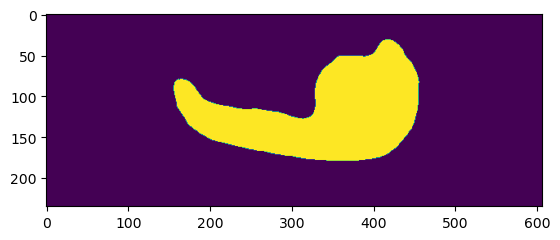

In [2]:
from skimage.measure import label, regionprops, regionprops_table

scale_x = 512
scale_y = 256

### resample to obtain desired pixel resoultion
target_res = 5.86 # um per pixel
rs_vector = res_array / target_res
rs_inv = np.floor(rs_vector**(-1)).astype(int)
rs_inv[0] = 1
rs_vector2 = np.multiply(rs_inv, rs_vector)
# set time index
t = 0

# extract image
imData = np.squeeze(imObject.get_image_data("CZYX", T=t))

# Step 1: block reduction. Essentially max pooling
imData_block = skimage.measure.block_reduce(imData, (rs_inv[0], rs_inv[1], rs_inv[2]), np.max)

# Step 2: rescale so that voxels are isotropic
imData_rs = scipy.ndimage.zoom(imData_block, rs_vector2)

# Step 3: find brightest Z pixels at each xy coordinate
max_z_b = np.argmax(imData_rs, 0)
max_b_z = np.max(imData_rs, 0) # and brightest pixel values

# Step 4: mask
threshold_sa = filters.threshold_sauvola(max_b_z, window_size=9)
fish_mask = (max_b_z < threshold_sa)*1 
fp = disk(10)
fish_closed = closing(fish_mask, fp) # morphological closing
fp_small = disk(5)
fish_strip = skimage.morphology.remove_small_objects(label(fish_closed), min_size=600) # remove small objects
fish_clean = skimage.morphology.binary_erosion(fish_strip, fp_small) # clean up edges
fish_clean = scipy.ndimage.binary_fill_holes(fish_clean)
plt.imshow(fish_clean)

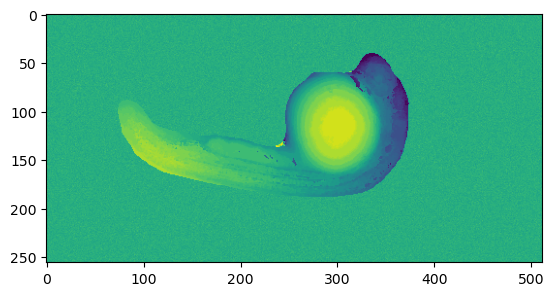

In [3]:
# max_z_b = max_b_z

# step 5: Normalize
mean_z = np.mean(max_z_b[np.where(fish_clean==1)])
std_z = np.std(max_z_b[np.where(fish_clean==1)])

im_norm = -(max_z_b-mean_z)/std_z

size_x = 512
size_y = 256

# step 6: use mask to replace background pixels with white noise
im_norm[np.where(fish_clean==0)] = np.random.normal(loc=0, scale=.1, size=(np.sum(fish_clean==0),))

# Step 7: resize and center image
regions = regionprops(label(fish_clean))
im_center = regions[0].centroid
im_centroid = np.round(im_center).astype(int)

im_array = np.random.normal(loc=0, scale=.1, size=(size_y, size_x)) # initialize array

xmin = max(im_centroid[1]-(size_x/2),0)
xmax = min(xmin+size_x, fish_clean.shape[1])
from_x = np.arange(xmin, xmax).astype(int)

ymin = max(im_centroid[0]-(size_y/2),0)
ymax = min(xmin+size_y, fish_clean.shape[0])
from_y = np.arange(ymin, ymax).astype(int)

c_diff_y = size_y/2 - im_center[0] + 0.5
c_diff_x = size_x/2 - im_center[1] + 0.5

to_y = np.round(from_y + c_diff_y).astype(int)
to_x = np.round(from_x + c_diff_x).astype(int)

im_array[to_y[0]:to_y[-1], to_x[0]:to_x[-1]] = im_norm[from_y[0]:from_y[-1], from_x[0]:from_x[-1]]

plt.imshow(im_array)

In [4]:
np.max(im_array)

1.7536878337770583

In [5]:
import umap
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
# apply UMAP dimensionality reduction (why not?)

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(im_array)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
import plotly.graph_objects as go
import plotly.express as px

fig = px.scatter(embedding[:, 0], embedding[:, 1], color=range(n_time_points))
fig.show()

ValueError: All arguments should have the same length. The length of argument `color` is 41, whereas the length of  previously-processed arguments ['x', 'index'] is 256